# Protein Folding

Seperating the code from all the notes of the protein folding notebook.

Imports

In [18]:
from matplotlib import pyplot as plt  #import matplotlib
import numpy                       #import numpy
import math
from IPython.display import display, Markdown
from scipy.optimize import leastsq
import pandas as pd

Constants

In [19]:
delta=3E-3        #The duration for which the gradients are applied: s
Delta=0.1         #A delay in the experiment: s
Gmax=6000         #This is the maximum gradient strength of the magnet: G m-1
gamma= 2.67522E4  #The proton Gyromagnetic ratio:  rad s-1 G-1
kb=1.381E-23      #Boltzmann's constant: Js-1 
pi=np.pi          #3.14159...
nu=1E-3           #the viscosity of water at 25oC
T0=273.19         #The temperature in K of 0oC
T=25              #the temperature where we ran these experiments (25oC): oC

m1 = 22123        #Molecular weights of the 5 proteins
m2 = 118250
m3 = 14230
m4 = 4500000
m5 = 623220

Read the file into a dataframe

In [20]:
protein1 = pd.read_csv('protein1.out',header=None,names=['G','I'],delim_whitespace=True)
protein1

,G,I
0,0.000000,1.001320e+06
1,0.052632,9.818368e+05
2,0.105263,9.664202e+05
3,0.157895,9.595538e+05
4,0.210526,9.334380e+05
5,0.263158,9.038141e+05
6,0.315789,8.761196e+05
7,0.368421,8.320696e+05
8,0.421053,8.002542e+05
9,0.473684,7.733541e+05


Calculate $k$ values using the equation $k=\gamma^2\delta^2 G^2 \left(\Delta - \frac{\delta}{3}\right) $

In [21]:
protein1['k'] = (protein1['G']*delta*gamma)**2.*(Delta-delta/3)

In [22]:
# Combines all of the CalcModel and chifunc functions
def chifunc(x,b):
    return (x[0]*np.exp(-b[0]*x[1])) - b[1]

def CalcModel(k,I0,DT):   
    return I0*np.exp(-k*DT)

def FitModel(I0guess,DTguess,k,I,verbose=False): #function to fit model (DT,I0 pars) to data (k,I)
#    Use leastsquares to fit the model to the data and find associated error values
    xinit=I0guess,DTguess
    pfit,pcov,infodict,errmsg,success=leastsq(chifunc,xinit,args=[k,I,],full_output=1) # the line that does the magic!

    if (len(I) > len(xinit)) and pcov is not None:
        s_sq = (chifunc(pfit,[k,I,])**2).sum()/(len(I)-len(xinit))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    perr = np.array(error) 
    
    if(verbose):
        print("These are the fitted parameters:")
        print("I0=",pfit[0],"+/-",perr[0])
        print("DT=",pfit[1],"+/-",perr[1])
        display(Markdown(rf'  Fitted D:   %.2e $\pm$ %.2e 'r'cm$^2$s$^{-1}$' % (pfit[0],pfit[1])))    
    return pfit[0],pfit[1],perr[0],perr[1]

def CalcK(G,gamma,delta,Delta): #calculate 'k' values from an array of G values using the constants
    return (G*delta*gamma)**2.*(Delta-delta/3.)

def Readin(infile): #function to read in a data file
    G=[]  #initialise a list to store G values
    I=[]  #initialise a lsit to store I values
    inny=open(infile) #open a 'stream' an interface to the file.
    for line in inny.readlines():  #loop over all lines in the file
        #print(line)      #uncomment this to see what it does
        test=line.split()  #this line splits the line into fields separated by 'whitespace'
        #print(test)      #uncomment this to see what it does
        if(len(test)>0): #make sure that the line has some information in!
            G.append(float(test[0])) #add the G value to the list
            I.append(float(test[1])) #add the I value to the list
    G=np.array(G)  #turn into a 'numpy' array
    I=np.array(I)  #turn into a 'numpy' array
    return G,I  

Actually performing the analysis on one of the proteins,

matches the given results from the original notebook

In [46]:
IO_guess = 2E6
DT_guess = 1E-8

fitted_model = FitModel(IO_guess, DT_guess, protein1['k'].to_numpy(), protein1['I'].to_numpy(), verbose=True)
fitted_model

These are the fitted parameters:
I0= 987306.6441529379 +/- 3210.370076267484
DT= 0.0018408807332644702 +/- 1.8364951134469547e-05


  Fitted D:   9.87e+05 $\pm$ 1.84e-03 cm$^2$s$^{-1}$

(987306.6441529379,
 0.0018408807332644702,
 3210.370076267484,
 1.8364951134469547e-05)

Plotting the data

In [24]:
file = 'protein1.out'

#DT will be in units of m2 s-1
def SimData(DTsim): #give this function a list of different diffusion coefficients 
    """Returns a plot of different DT values on the same graph"""
    fig=plt.figure()                  #setup the plot
    ax=fig.add_axes([0,0,1,1])        #setup the plot
    G=np.linspace(0,1,20)   #calculate an arbitrary range of Gradients from 0 to 100% of maximum (0-1)
    I0=1E6                             #arbitrary I0 value           
    ax.set_ylim(0,1.05)               #set yrange from 0, to just above the max number (1.0)
    ax.set_xlabel("G/Gmax")           #set the Xlabel
    ax.set_ylabel("I/I0")             #set the Ylabel

    for DT in DTsim:  #loop over all the test DT values in the list sent to function (DTsim)
        k=CalcK(G*Gmax,gamma,delta,Delta)  #calc the 'k' values
        I=CalcModel(k,I0,DT)               #simulate the model
        I0fit,DTfit,I0err,DTerr=FitModel(2E6,1E-12,k,I) #fit the simulated model to get a nice line
        Ifit=CalcModel(k,I0fit,DTfit)      #back-calculate the simulated data for plotting

        label='%.2e m^2s^{-1}'% DT
        ax.scatter(G,I/I0)   #make the plot of data (points)
        ax.plot(G,Ifit/I0fit,label=label)   #make the plot of data (lines)
    ax.legend(loc='lower left')
        
def SetFig():
    """Creates blank plot for data to be added to later"""
    fig=plt.figure()                  #setup the plot
    ax=fig.add_axes([0,0,1,1])        #setup the plot
    ax.set_ylim(0,1.05)               #set yrange from 0, to just above the max number (1.0)
    ax.set_xlabel("G/Gmax")           #set the Xlabel
    ax.set_ylabel("I/I0")             #set the Ylabel
    return fig,ax    

        
def FitFile(file,verbose=False,ax=None): #give this function a list of different diffusion coefficients 
    """For a file of data, retrun the fitted model and plot the results"""
    G,I=Readin(file)       #read in text file using our own code
    
    if(verbose): #if verbose is set to true, then initialise a stand-alone figure
         fig,ax=SetFig() #otherwise code assumes SetFig has been called already to get a multi-plot

    k=CalcK(G*Gmax,gamma,delta,Delta)  #calc the 'k' values
    I0fit,DTfit,I0err,DTerr=FitModel(2E6,1E-8,k,I,verbose=verbose) #fit the simulated model to get a nice line
    Ifit=CalcModel(k,I0fit,DTfit)      #back-calculate the simulated data for plotting
    I0=1E6
 
    ax.scatter(G,I/I0)   #make the plot of data (points)
    ax.plot(G,Ifit/I0fit,label=file)   #make the plot of data (lines)

    if(verbose): #show legend if just making a single plot
        ax.legend()

    return DTfit,DTerr  #return fitted diffusion coefficient

def Readin(infile): #function to read in a data file
    G=[]  #initialise a list to store G values
    I=[]  #initialise a lsit to store I values
    inny=open(infile) #open a 'stream' an interface to the file.
    for line in inny.readlines():  #loop over all lines in the file
        #print(line)      #uncomment this to see what it does
        test=line.split()  #this line splits the line into fields separated by 'whitespace'
        #print(test)      #uncomment this to see what it does
        if(len(test)>0): #make sure that the line has some information in!
            G.append(float(test[0])) #add the G value to the list
            I.append(float(test[1])) #add the I value to the list
    G=numpy.array(G)  #turn into a 'numpy' array
    I=numpy.array(I)  #turn into a 'numpy' array
    return G,I  

In [25]:
def ExpectedD(Mw,DT,DTerr,verbose=False): #print diffusion coefficients to the screen for folded and unfolded for the given molecular weight.
    """Given the MW of a protein, calculate the folded and unfolded DT values,
    and use these to calculate the constant n amd its associated error"""
    from IPython.display import display, Markdown
    
    #The two results from Wilkins et al.
    #Rh unfolded =2.21*(Mw/110.)** 0.57 #in Angstroms
    #Rh folded=4.75*(Mw/110.)** 0.29    #in Angstroms
    #D=k T/(6 pi nu R)  #Stokes Einstein equation #units of m^2s-1 for D
    #Average molecular weight of an amino acid = 110 g mol-1

    kfol=kb* (T0+T)* 110**0.29 /(6* pi* nu* 4.75 *1E-10)  #conversion factors from Einstein-Stokes
    kunf=kb* (T0+T)* 110**0.57 /(6* pi* nu* 2.21 *1E-10)   #conversion factors from Einstein-Stokes
    Dfol=kfol*(Mw)**(-0.29)  
    Dunf=kunf*(Mw)**(-0.57)
    #print(kfol,kunf)
    fac=(DT-Dunf)/(Dfol-Dunf)  #back calulating the unfolded fraction.
    facErr=(DTerr**2.*(1./(Dfol-Dunf))**2.)**0.5 
    if(verbose):
        display(Markdown(rf'  Expected D (unfolded): %.2e 'r'm$^2$s$^{-1}$' % (Dunf)))
        display(Markdown(rf'  Expected D (folded):   %.2e 'r'm$^2$s$^{-1}$' % (Dfol)))    
        display(Markdown(rf'  Folded factor $\eta$:   %.4f $pm %.4f' % (fac,facErr )))  #propagating the error, so fractional error in DT->fraction error in fac  
    return fac,facErr


In [ ]:
protein5 = pd.read_csv('protein5.out',header=None,names=['G','I'],delim_whitespace=True)
protein5['k'] = (protein5['G']*delta*gamma)**2.*(Delta-delta/3)
fitted_model5 = FitModel(2E6, 1E-8, protein5['k'].to_numpy(), protein5['I'].to_numpy(), verbose=True)
b = ExpectedD(m5, fitted_model5[1], fitted_model5[3], True)

# Task 1 and Task 2

In [30]:
weights = [m1, m2, m3, m4, m5]

Protein 1.............................................

These are the fitted parameters:
I0= 987306.6441460623 +/- 3210.3700715296964
DT= 5.113557592196961e-11 +/- 5.101375280146457e-13


  Fitted D:   9.87e+05 $\pm$ 5.11e-11 cm$^2$s$^{-1}$

  Expected D (unfolded): 4.81e-11 m$^2$s$^{-1}$

  Expected D (folded):   9.88e-11 m$^2$s$^{-1}$

  Folded factor $\eta$:   0.0601 $pm 0.0101

Protein 1 is not folded 


Protein 2.............................................

These are the fitted parameters:
I0= 1005362.6137123436 +/- 3252.4818506533493
DT= 5.849456407208256e-11 +/- 5.466198713462525e-13


  Fitted D:   1.01e+06 $\pm$ 5.85e-11 cm$^2$s$^{-1}$

  Expected D (unfolded): 1.85e-11 m$^2$s$^{-1}$

  Expected D (folded):   6.08e-11 m$^2$s$^{-1}$

  Folded factor $\eta$:   0.9465 $pm 0.0129

Protein 2 is folded (mostly)


Protein 3.............................................

These are the fitted parameters:
I0= 1002337.3011250461 +/- 3059.1788782724325
DT= 6.255746598463525e-11 +/- 5.369475111938806e-13


  Fitted D:   1.00e+06 $\pm$ 6.26e-11 cm$^2$s$^{-1}$

  Expected D (unfolded): 6.18e-11 m$^2$s$^{-1}$

  Expected D (folded):   1.12e-10 m$^2$s$^{-1}$

  Folded factor $\eta$:   0.0143 $pm 0.0106

Protein 3 is not folded 


Protein 4.............................................

These are the fitted parameters:
I0= 1002136.2952060581 +/- 4514.265661991407
DT= 2.1171987163449926e-11 +/- 5.199107624616374e-13


  Fitted D:   1.00e+06 $\pm$ 2.12e-11 cm$^2$s$^{-1}$

  Expected D (unfolded): 2.32e-12 m$^2$s$^{-1}$

  Expected D (folded):   2.11e-11 m$^2$s$^{-1}$

  Folded factor $\eta$:   1.0013 $pm 0.0276

Protein 4 is folded (mostly)


Protein 5.............................................

These are the fitted parameters:
I0= 991860.6474968756 +/- 3839.9085709648584
DT= 3.0607544016912395e-11 +/- 4.920679926172242e-13


  Fitted D:   9.92e+05 $\pm$ 3.06e-11 cm$^2$s$^{-1}$

  Expected D (unfolded): 7.17e-12 m$^2$s$^{-1}$

  Expected D (folded):   3.75e-11 m$^2$s$^{-1}$

  Folded factor $\eta$:   0.7723 $pm 0.0162

Protein 5 is folded (mostly)




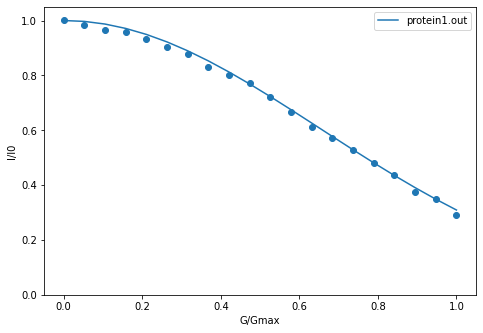

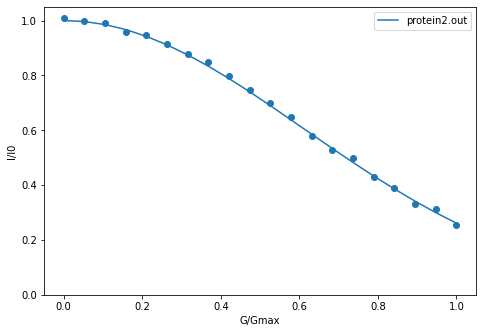

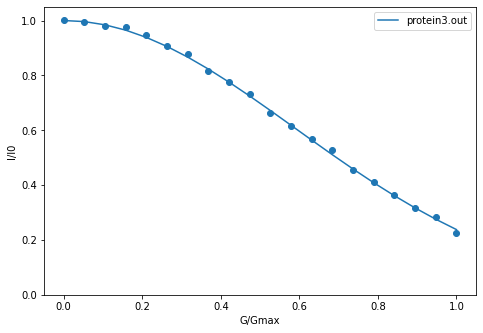

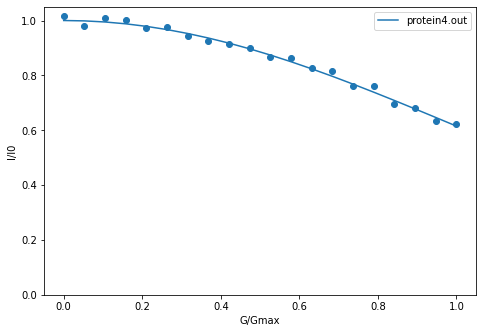

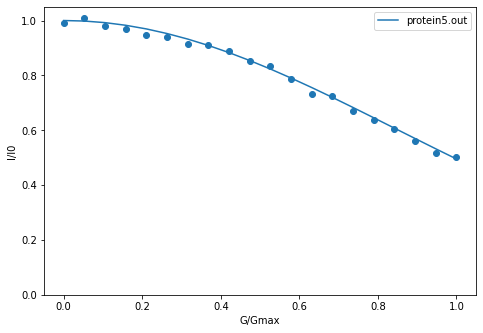

In [45]:
for i, weight in enumerate(weights):
    print(f"Protein {i+1}.............................................\n")
    file = f"protein{i+1}.out"
    DT,DTerr=FitFile(file,verbose=True)
    fac,facErr=ExpectedD(weight,DT,DTerr,verbose=True)
    if (1 - fac) < (fac): 
        print(f"Protein {i+1} is folded (mostly)\n\n")
    else:
        print(f"Protein {i+1} is not folded \n\n")

# Task 3 

Research $\alpha$-synuclein (protein 3) and a ribosome assembly (protein 4) and determine if they're folded or not.

These are the fitted parameters:
I0= 1002337.3011250461 +/- 3059.1788782724325
DT= 6.255746598463525e-11 +/- 5.369475111938806e-13


  Fitted D:   1.00e+06 $\pm$ 6.26e-11 cm$^2$s$^{-1}$

  Expected D (unfolded): 6.18e-11 m$^2$s$^{-1}$

  Expected D (folded):   1.12e-10 m$^2$s$^{-1}$

  Folded factor $\eta$:   0.0143 $pm 0.0106

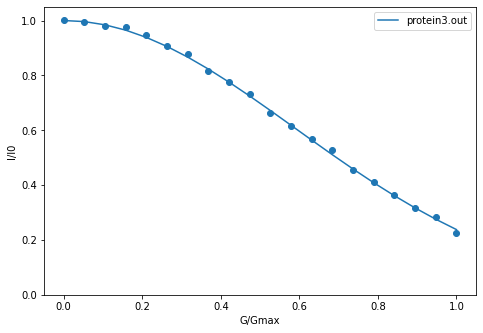

In [27]:
# protein 3 (alpha synuclein)

file = 'protein3.out'
DT,DTerr=FitFile(file,verbose=True)
fac,facErr=ExpectedD(m3,DT,DTerr,verbose=True)

#### $\alpha$-Synuclein

$\alpha$-Synuclein is a protein that's linked genetically and neuropathically to Parkinsons disease, abundant abnormal accumulation of $\alpha$-Synuclein characterises neuropathological specimens not only from patients with Parkinson's Disease but also from other neurodegenerative conditions  (2012 Stefanis L.) The typiucal function of $\alpha$-Synuclein remains poorly understood, however it has also been found in 'senile plaques' of people with alzheimers. It has been found to localize in the nerve terminal and has an effect on synaptic transmission. (2013 Jacob Bendor , Todd Logan and Robert H. Edwards). When a protein is folded it becomes biologically and chemically active however the $\alpha$-Synuclein the data is collected from in the file is not folded. The folded factor $\eta$ of 0.0143 shows that the protein is not folded. As it is not folded it is still just a chain of polypeptides and does not actually do react or do anything.


##### Sources
The Function of $\alpha$-Synuclein - 2013 - Jacob Bendor , Todd Logan and Robert H. Edwards - National Library of Medicine - [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3866954/)

$\alpha$-Synuclein in Parkinson's Disease - 2012 - Leonidas Stefanis - National Library of Medicine - [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3281589/)

These are the fitted parameters:
I0= 1002136.2952060581 +/- 4514.265661991407
DT= 2.1171987163449926e-11 +/- 5.199107624616374e-13


  Fitted D:   1.00e+06 $\pm$ 2.12e-11 cm$^2$s$^{-1}$

  Expected D (unfolded): 2.32e-12 m$^2$s$^{-1}$

  Expected D (folded):   2.11e-11 m$^2$s$^{-1}$

  Folded factor $\eta$:   1.0013 $pm 0.0276

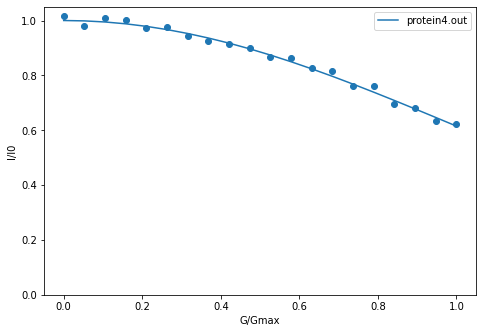

In [28]:
# protein 4 (ribosome assembly)

file = 'protein4.out'
DT,DTerr=FitFile(file,verbose=True)
fac,facErr=ExpectedD(m4,DT,DTerr,verbose=True)

#### Ribosome Assembly
A ribosome is the site of protein synthesis from amino acids in a cell. Ribosomes exist in both eukaryotic and prokaryotic cells. The ribosome reads the sequence of mRNA and decodes it into the required gentic information and then uses that to form a series of amino acids. From the folded factor $\eta$ being effectively 1 we can say that this ribosome assembly is folded and therefore biologically and chemically functional. This means that it would be producing/synthesising new proteins